<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-LinearRegression" data-toc-modified-id="Модель-LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель LinearRegression</a></span></li><li><span><a href="#Модель-RandomForest" data-toc-modified-id="Модель-RandomForest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель RandomForest</a></span></li><li><span><a href="#Модель-LightGBM" data-toc-modified-id="Модель-LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель LightGBM</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [2]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from time import perf_counter

import optuna
from optuna.integration import OptunaSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split ,cross_val_score, RandomizedSearchCV, TimeSeriesSplit
from sklearn import set_config

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


## Подготовка

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, расположены ли даты по порядку возрастания.

In [6]:
data.index.is_monotonic

True

Проведем ресемплирование по одному часу.

In [7]:
data = data.resample('1H').sum()
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


**Вывод:** Рассмотрены данные о заказах такси в аэропортах за 2018 год. Данные представляют собой временной ряд с количеством заказов с временным шагом 10 минут. Проведено ресемплирование ряда по одному часу.

## Анализ

In [8]:
# Установим фон графиков
sns.set_theme(style='darkgrid')

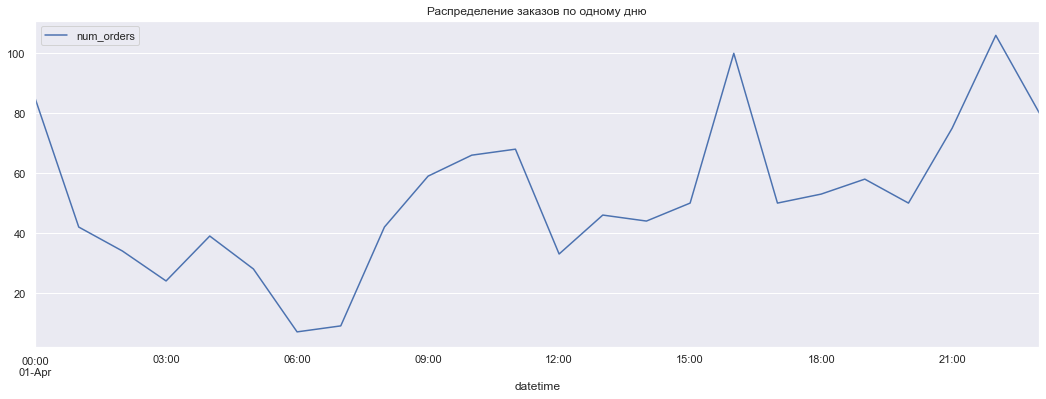

In [9]:
data['2018-04-01':'2018-04-01'].plot(figsize=(18,6), title='Распределение заказов по одному дню')
plt.show()

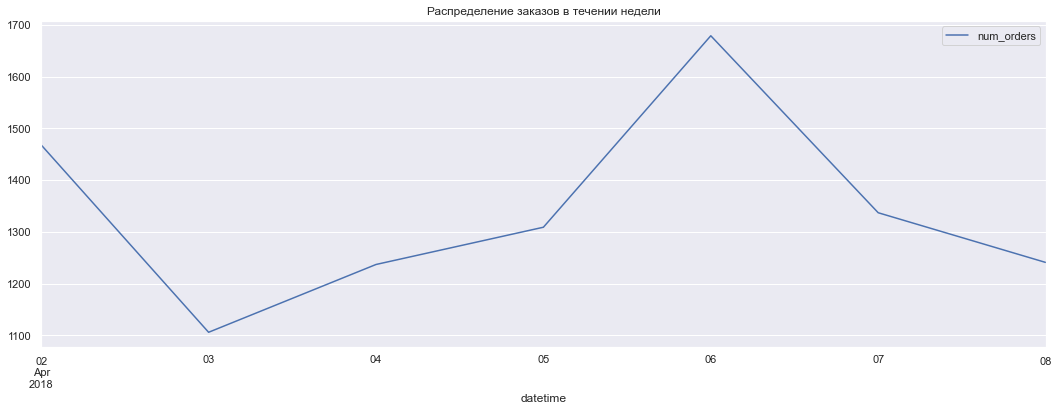

In [10]:
data.resample('1D').sum()['2018-04-02':'2018-04-08'].plot(figsize=(18,6), title='Распределение заказов в течении недели')
plt.show()

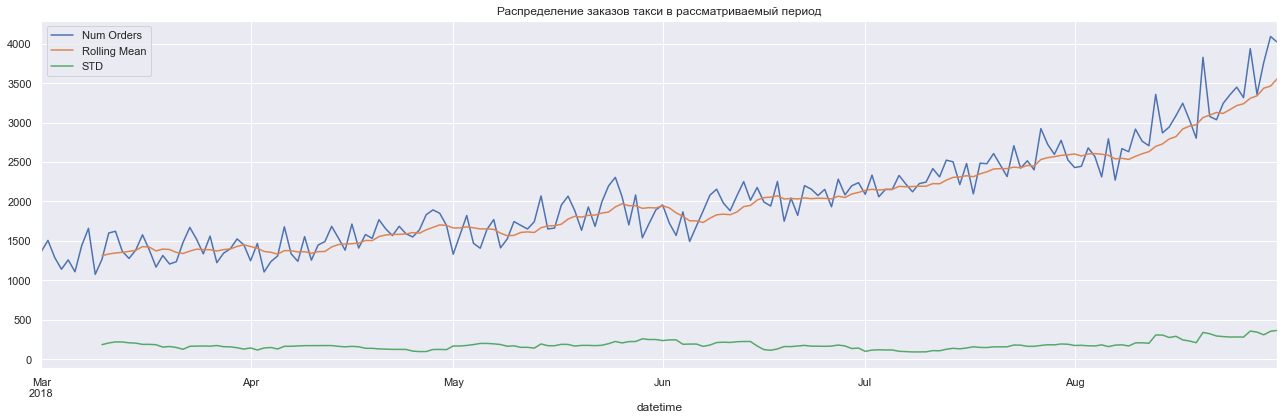

In [11]:
data.resample('1D').sum().plot(ax=plt.gca(),figsize=(18,6), title='Распределение заказов такси в рассматриваемый период')
data.resample('1D').sum().rolling(10).mean().plot(ax=plt.gca(),figsize=(18,6))
data.resample('1D').sum().rolling(10).std().plot(ax=plt.gca(),figsize=(18,6))
plt.legend(['Num Orders', 'Rolling Mean', 'STD'])
plt.tight_layout()
plt.show()

Рассмотрим тренды и сезонность временного ряда.

In [12]:
col_palet = sns.color_palette()

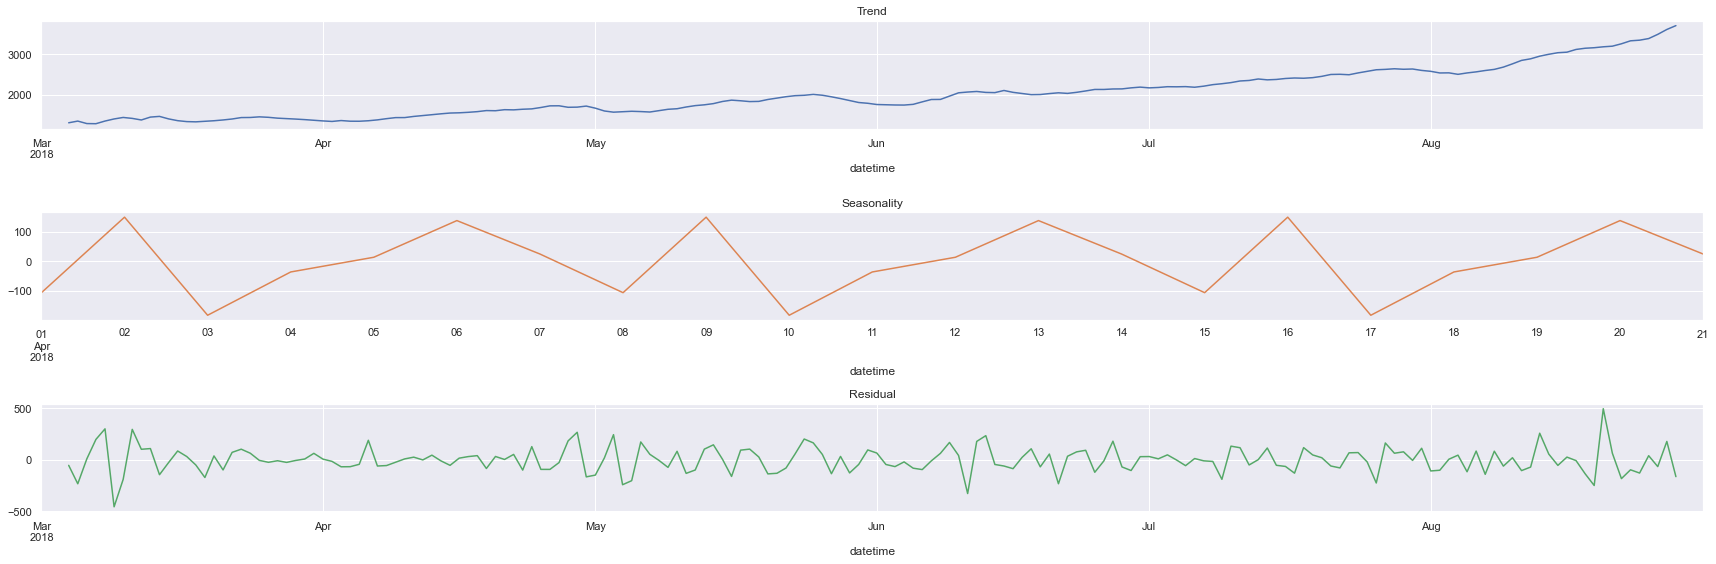

In [13]:
decomposed = seasonal_decompose(data.resample('1D').sum())

plt.figure(figsize=(24,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color = col_palet[1], xlim=['2018-04-01','2018-04-21'])
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color = col_palet[2])
plt.title('Residual')

plt.tight_layout()

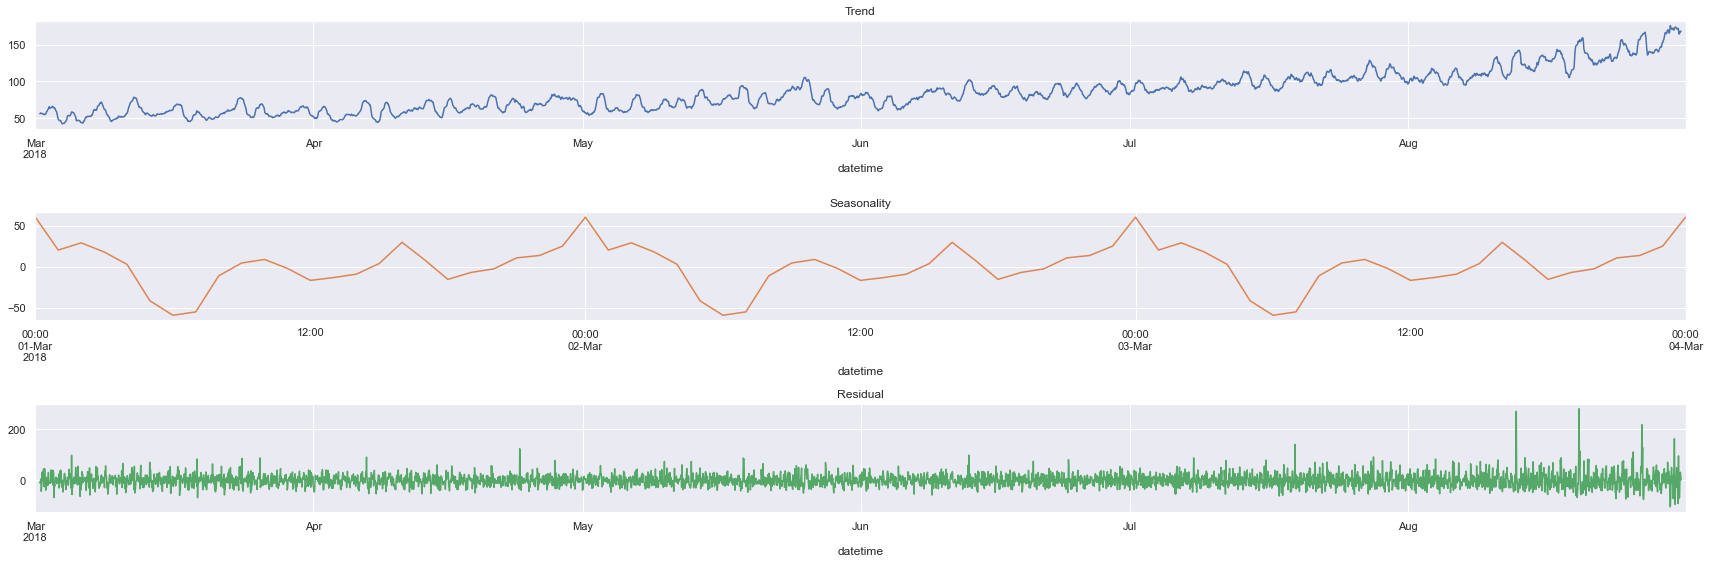

In [14]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(24,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color = col_palet[1], xlim=['2018-03-01','2018-03-04'])
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color = col_palet[2])
plt.title('Residual')

plt.tight_layout()

**Вывод:** 
* Большое количество заказов в течении одного дня в вечернее время и до полуночи.
* Больше всего заказов в понедельник и пятницу, меньше всего во вторник и воскресенье.
* Рассматриваемый временной ряд является нестационарным.
* Просматривается сезонность по дням и по неделям.

## Обучение

Напишем функцию для добавления в датасет признаков:
* Год
* Месяц
* День
* День недели
* Отстающие значения
* Скользящее среднее

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    
    shape_before = data.shape
    
    df = data.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

Добавим новые признаки.

In [16]:
data_preprocessed = make_features(data,17,38)

In [17]:
print(f'Размер выборки до: {data.shape}')
print(f'Размер выборки после добавления новых признаков: {data_preprocessed.shape}')

Размер выборки до: (4416, 1)
Размер выборки после добавления новых признаков: (4416, 23)


Подготовка выборок.

In [18]:
train, test = train_test_split(data_preprocessed, test_size=0.1, shuffle=False)

train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

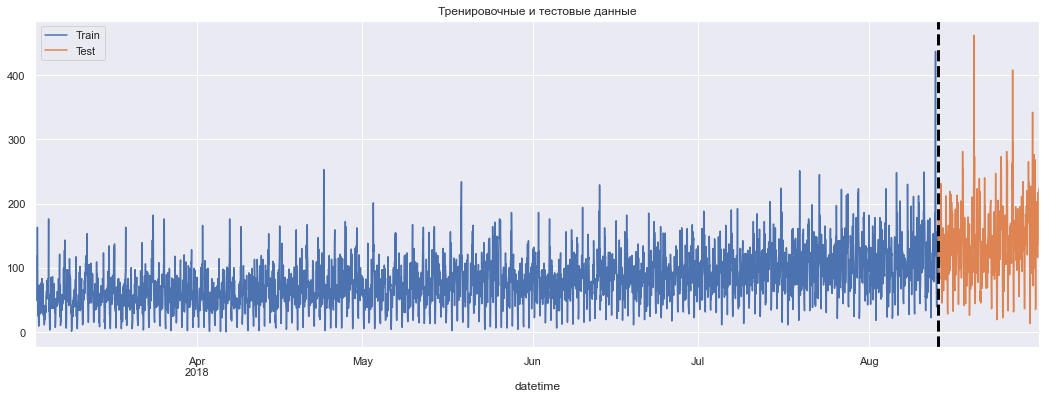

In [19]:
fig, ax = plt.subplots(figsize=(18,6))
train.plot(ax=ax, y='num_orders', label='Train')
test.plot(ax=ax, y='num_orders', label='Test')
plt.axvline(test.iloc[:1].index.values, color = 'black', ls='--', linewidth=3)
plt.title('Тренировочные и тестовые данные')
plt.show()

In [20]:
# Зададимся random_state
RANDOM_STATE = 808

In [21]:
# Добавим TimeSeriesSplit для разбивки временного ряда при кросс валидации
tscv = TimeSeriesSplit(n_splits=5, test_size=24*30) #test_size, gap

In [22]:
# Словарь для результатов работы рассматриваемых моделей
results = {}

Напишем функцию для сбора результатов метрики на модели, определения время fit и predict, а так же построения графика Feature Inmportances.

In [23]:
def ModelResults(model_search, model_name, results):
    
    model = model_search.best_estimator_
    
    #Определим время fit модели 
    t_start_1 = perf_counter()
    model.fit(features_train, target_train)
    t_stop_1 = perf_counter()

    #Определим время predict модели 
    t_start_2 = perf_counter()
    model.predict(features_train)
    t_stop_2 = perf_counter()

    results[model_name] = [abs(model_search.best_score_), t_stop_1 - t_start_1, t_stop_2 - t_start_2]

    pd.DataFrame(model.feature_importances_, 
                       index = features_train.columns, 
                       columns =['Importance']).sort_values(by='Importance').plot(kind='barh', figsize = (18,6), title ='Feature Importances')
    plt.show()

### Модель LinearRegression

In [24]:
model_linear = LinearRegression()

t_start_1 = perf_counter()
model_linear.fit(features_train, target_train)
t_stop_1 = perf_counter()

t_start_2 = perf_counter()
pred_train = model_linear.predict(features_train)
t_stop_2 = perf_counter()

results['Linear Regression'] = [abs(cross_val_score(
                model_linear, features_train,target_train, scoring = 'neg_root_mean_squared_error', cv=tscv)).mean(), t_stop_1 - t_start_1, t_stop_2 - t_start_2]

print("RMSE обучающей выборки на кросс-валидации:", abs(cross_val_score(
                LinearRegression(), features_train,target_train, scoring = 'neg_root_mean_squared_error', cv=tscv)).mean())

RMSE обучающей выборки на кросс-валидации: 30.850814232695946


### Модель RandomForest

[I 2023-02-11 11:16:27,993] A new study created in memory with name: no-name-9dba5de6-8c25-4130-9e53-7d90d68f774a
[I 2023-02-11 11:16:39,192] Trial 14 finished with value: -29.530322833341664 and parameters: {'max_depth': 6, 'min_samples_split': 5}. Best is trial 14 with value: -29.530322833341664.
[I 2023-02-11 11:16:40,504] Trial 9 finished with value: -29.08613926306642 and parameters: {'max_depth': 7, 'min_samples_split': 2}. Best is trial 9 with value: -29.08613926306642.
[I 2023-02-11 11:16:41,767] Trial 0 finished with value: -28.73707257412334 and parameters: {'max_depth': 8, 'min_samples_split': 5}. Best is trial 0 with value: -28.73707257412334.
[I 2023-02-11 11:16:42,095] Trial 6 finished with value: -28.70381371096247 and parameters: {'max_depth': 8, 'min_samples_split': 2}. Best is trial 6 with value: -28.70381371096247.
[I 2023-02-11 11:16:43,029] Trial 4 finished with value: -28.499080571313886 and parameters: {'max_depth': 9, 'min_samples_split': 4}. Best is trial 4 wit



Лучшие параметры: {'max_depth': 20, 'min_samples_split': 3}
RMSE на тренировочной выборке: 27.869335705883184


RandomForestRegressor(max_depth=20, min_samples_split=3, random_state=808)

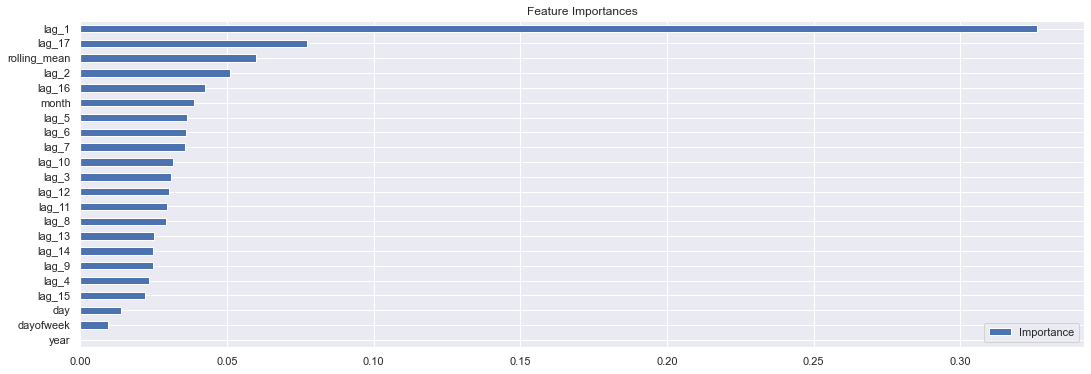

Wall time: 44.4 s


In [25]:
%%time

RF_model = RandomForestRegressor(random_state=RANDOM_STATE)

parameters_RF = {
              'max_depth': optuna.distributions.IntDistribution(3,20),
              'min_samples_split': optuna.distributions.IntDistribution(2, 5)} 


optuna_search_RF = OptunaSearchCV(RF_model, parameters_RF, n_trials=30, cv=tscv, 
                                  n_jobs=-1, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE, timeout=600) 
optuna_search_RF.fit(features_train, target_train)

#results['RandomForest'] = abs(optuna_search_RF.best_score_)

print('\n')
print(f'Лучшие параметры: {optuna_search_RF.best_params_}')
print(f'RMSE на тренировочной выборке: {abs(optuna_search_RF.best_score_)}')
display(optuna_search_RF.best_estimator_)
ModelResults(optuna_search_RF, 'Random Forest', results)

### Модель LightGBM

[I 2023-02-11 11:17:12,440] A new study created in memory with name: no-name-84728cb2-d9c1-419b-8113-c40b4298ffb3
[I 2023-02-11 11:17:16,261] Trial 6 finished with value: -29.589114823683115 and parameters: {'max_depth': 100, 'learning_rate': 0.019198726218201193, 'n_estimators': 100}. Best is trial 6 with value: -29.589114823683115.
[I 2023-02-11 11:17:18,474] Trial 12 finished with value: -36.91248479692265 and parameters: {'max_depth': 200, 'learning_rate': 0.0015730117064248457, 'n_estimators': 150}. Best is trial 6 with value: -29.589114823683115.
[I 2023-02-11 11:17:18,985] Trial 15 finished with value: -28.37983555637024 and parameters: {'max_depth': 150, 'learning_rate': 0.07215043556762878, 'n_estimators': 150}. Best is trial 15 with value: -28.37983555637024.
[I 2023-02-11 11:17:19,160] Trial 4 finished with value: -37.602247541603205 and parameters: {'max_depth': 300, 'learning_rate': 0.001146790656516644, 'n_estimators': 150}. Best is trial 15 with value: -28.37983555637024



Лучшие параметры: {'max_depth': 250, 'learning_rate': 0.03394583177158857, 'n_estimators': 300}
RMSE на тренировочной выборке: 28.17603845613986


LGBMRegressor(learning_rate=0.03394583177158857, max_depth=250,
              n_estimators=300, random_state=808)

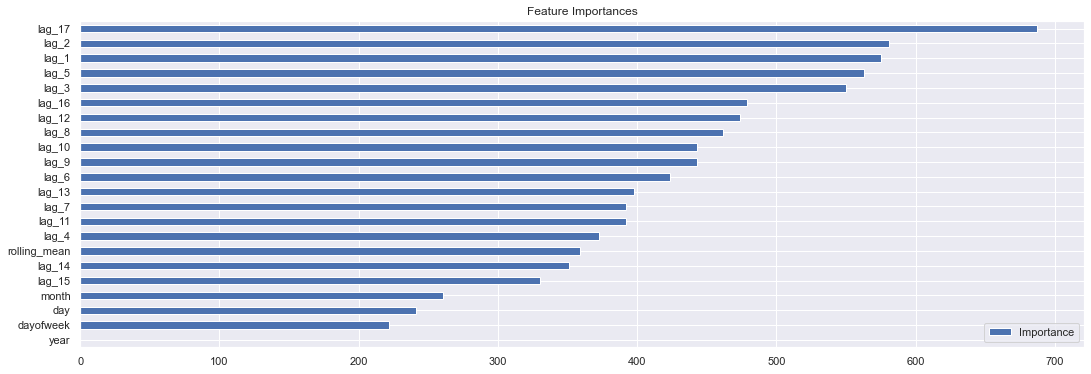

Wall time: 19.3 s


In [26]:
%%time

lgbm =  LGBMRegressor(random_state=RANDOM_STATE)

lgbm_params = {
    'max_depth': optuna.distributions.IntDistribution(100, 300, step=50),
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),  
    'n_estimators': optuna.distributions.IntDistribution(100, 300, step=50)
}


optuna_search_lgbm = OptunaSearchCV(lgbm, lgbm_params, n_trials=30, cv=tscv, 
                                    n_jobs=-1, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE, timeout=600) 
optuna_search_lgbm.fit(features_train, target_train)

#results['LightGBM'] = abs(optuna_search_lgbm.best_score_)

print('\n')
print(f'Лучшие параметры: {optuna_search_lgbm.best_params_}')
print(f'RMSE на тренировочной выборке: {abs(optuna_search_lgbm.best_score_)}')
display(optuna_search_lgbm.best_estimator_)
ModelResults(optuna_search_lgbm, 'LightGBM', results)

### Модель CatBoost

[I 2023-02-11 11:17:31,769] A new study created in memory with name: no-name-d635ef86-d851-41c0-a0b1-d4ddaf6cf86a
[I 2023-02-11 11:17:36,509] Trial 11 finished with value: -28.429390509683504 and parameters: {'depth': 3, 'learning_rate': 0.15000000000000002, 'iterations': 135}. Best is trial 11 with value: -28.429390509683504.
[I 2023-02-11 11:17:39,673] Trial 3 finished with value: -28.072730171112674 and parameters: {'depth': 4, 'learning_rate': 0.15000000000000002, 'iterations': 283}. Best is trial 3 with value: -28.072730171112674.
[I 2023-02-11 11:17:49,577] Trial 5 finished with value: -28.270690019074628 and parameters: {'depth': 5, 'learning_rate': 0.18000000000000002, 'iterations': 459}. Best is trial 3 with value: -28.072730171112674.
[I 2023-02-11 11:17:52,131] Trial 16 finished with value: -29.294219669137362 and parameters: {'depth': 4, 'learning_rate': 0.02, 'iterations': 298}. Best is trial 3 with value: -28.072730171112674.
[I 2023-02-11 11:17:57,334] Trial 12 finished 



Лучшие параметры: {'depth': 5, 'learning_rate': 0.060000000000000005, 'iterations': 650}
RMSE на тренировочной выборке: 27.59210828676847


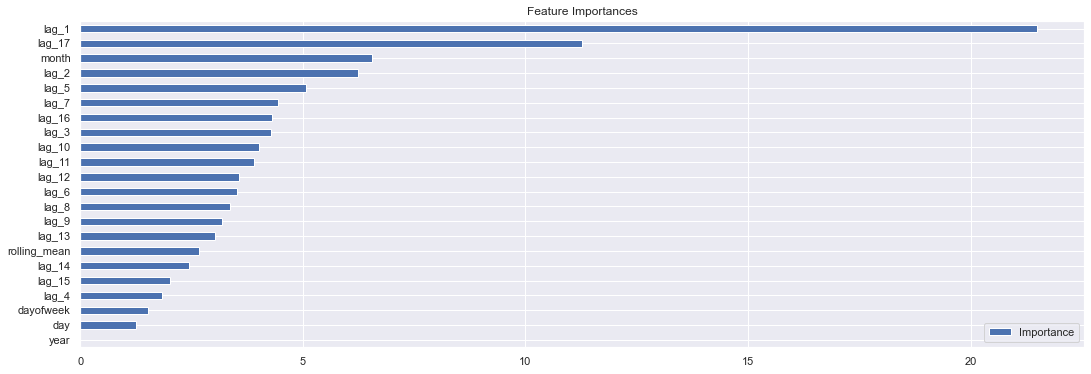

Wall time: 26min 19s


In [27]:
%%time

cat_model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False, early_stopping_rounds=300)

parameters = {'depth': optuna.distributions.IntDistribution(3, 12), 
              'learning_rate': optuna.distributions.FloatDistribution(0.01, 0.2, step=0.01), 
              'iterations': optuna.distributions.IntDistribution(100, 1000)}


optuna_search_cat = OptunaSearchCV(cat_model, parameters, n_trials=30, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE, timeout=600) 
optuna_search_cat.fit(features_train, target_train)

#results['CatBoost'] = abs(optuna_search_cat.best_score_)

print('\n')
print(f'Лучшие параметры: {optuna_search_cat.best_params_}')
print(f'RMSE на тренировочной выборке: {abs(optuna_search_cat.best_score_)}')
#display(optuna_search_cat.best_estimator_)
ModelResults(optuna_search_cat, 'CatBoost', results)

Полученные результаты.

In [28]:
res_df = pd.DataFrame(results, index = ['RMSE', 'Fit time,s', 'Prediction time,s'], columns = results.keys() )
res_df

,Linear Regression,Random Forest,LightGBM,CatBoost
RMSE,30.850814,27.869336,28.176038,27.592108
"Fit time,s",0.018301,4.653631,0.252809,1.023927
"Prediction time,s",0.001326,0.047788,0.007965,0.002110


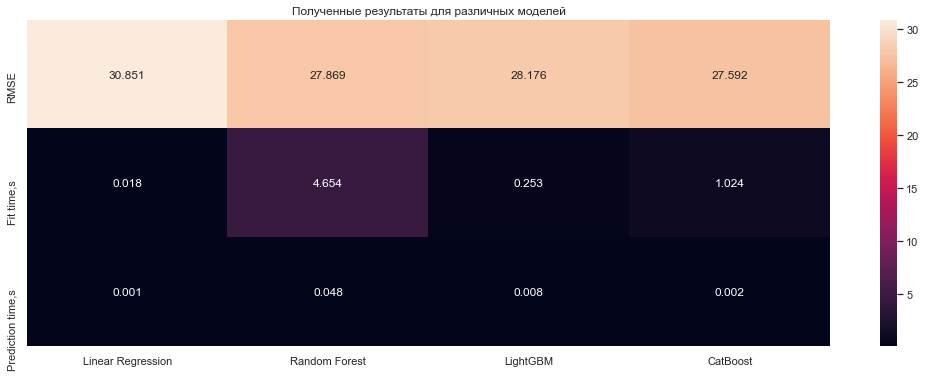

In [29]:
plt.figure(figsize=(18,6))
sns.heatmap(res_df, annot=True, fmt = '.3f')
plt.title('Полученные результаты для различных моделей')
plt.show()

**Вывод:**
* Наилучший результат по метрике RMSE показала модель CatBoost.

## Тестирование

In [30]:
cat_predictions = optuna_search_cat.predict(features_test)
print(f'RMSE на тестовой выборке для CatBoost: {mean_squared_error(target_test, cat_predictions) ** 0.5}')

RMSE на тестовой выборке для CatBoost: 45.99851534552034


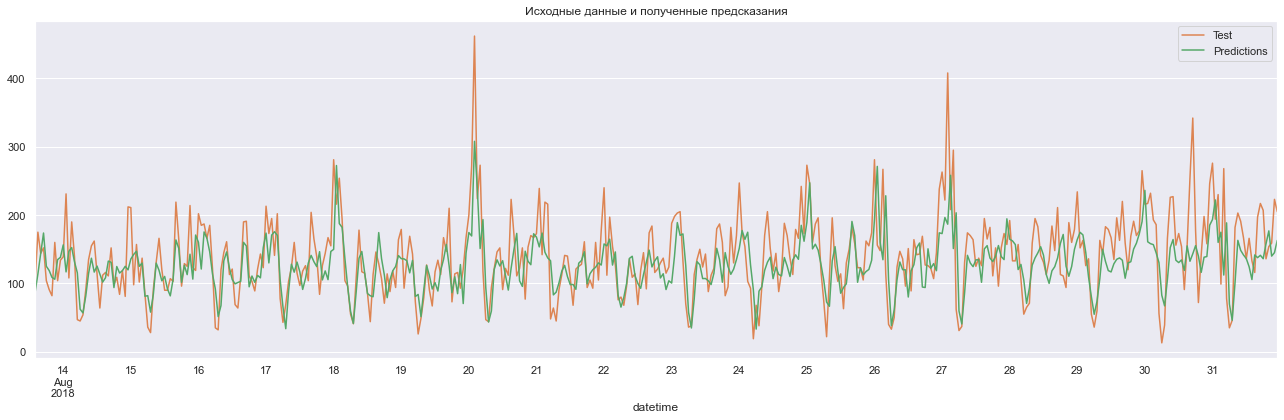

In [31]:
test['num_orders'].plot(ax=plt.gca(),figsize=(18,6), title='Исходные данные и полученные предсказания', color = col_palet[1])
pd.DataFrame(cat_predictions, index=features_test.index).plot(ax=plt.gca(),figsize=(18,6), color = col_palet[2])
plt.legend(['Test', 'Predictions'])
plt.tight_layout()
plt.show()

**Вывод:**
* Полученная метрика на тестовой выборке удовлетворяет условиям технического задания.

## Общий вывод

- Рассмотрены данные о заказах такси в аэропортах за 2018 год. Данные представляют собой временной ряд с количеством заказов с временным шагом 10 минут. Проведено ресемплирование ряда по одному часу.
- Большое количество заказов в течении одного дня в вечернее время и до полуночи. Рассматриваемый временной ряд является нестационарным. Период сезонности меньше месяца.
- Данные предобработаны. Добавлены новые признаки: год, месяц, день, день недели, отстающие значения, скользящее среднее.
- Наилучший результат по метрике RMSE показала модель CatBoost.
- Полученная метрика на тестовой выборке удовлетворяет условиям технического задания.